<a href="https://colab.research.google.com/github/rromerov/Proyecto_Integrador/blob/main/Avance4/Avance4.12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instituto Tecnológico y de Estudios Superiores de Monterrey
## Maestría en Inteligencia Artificial Aplicada
### Proyecto Integrador (Gpo 10) - TC5035.10

### **Proyecto: Diseño Acelerado de Fármacos**

### Avance 4: Modelos Alternativos

#### **Docentes:**
- Dra. Grettel Barceló Alonso - Profesor Titular
- Dr. Luis Eduardo Falcón Morales - Profesor Titular
- Dr. Ricardo Ambrocio Ramírez Mendoza  – Profesor Tutor

#### **Miembros del equipo:**
- Ernesto Enríquez Rubio - A01228409
- Roberto Romero Vielma - A00822314
- Herbert Joadan Romero Villarreal –  A01794199



---


### Modelos Alternativos
#### Background:

¿Cómo ayuda a un proyecto de IA el tener modelos alternativos además del baseline?

TODO:



---

### Selección de modelos

Justificar que modelos y porqué







---

### Código para el modelo

In [51]:
# Instalación bayesian-optimization
%%capture
!pip install scikit-optimize

In [66]:
# Importar librerías necesarias
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab import drive
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import learning_curve
import numpy as np
import warnings
from sklearn.exceptions import ConvergenceWarning

from skopt import gp_minimize
from skopt.space import Integer, Real
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, explained_variance_score, max_error, median_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet

In [53]:
# Cargar Google Drive al notebook
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
# Cargar el dataset
ruta_archivo_bioactivity = '/content/drive/My Drive/Colab Notebooks/data/bioactivity_data_2class_pIC50_pubchem_fp.csv'

# Lee el archivo CSV en un DataFrame
df_bioactivity = pd.read_csv(ruta_archivo_bioactivity)

# Mostrar que se haya importado correctamente el archivo
df_bioactivity.head(5)

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,pIC50
0,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.481486
1,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.769551
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.283997
3,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.522879
4,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.853872


#### Etiquetas y variable objetivo

The Neuropilin-1 data set contains 881 input features and 1 output variable (pIC50 values).


In [55]:
# Se define conjunto X para las etiquetas
X = df_bioactivity.drop('pIC50', axis=1)
# Mostrar contenido en el conjunto de X
X

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
58,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
59,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
60,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [56]:
# Se define variable Y para el objetivo
Y = df_bioactivity.pIC50
# Mostrar contenido en el conjunto de Y
Y

0     4.481486
1     4.769551
2     4.283997
3     4.522879
4     4.853872
        ...   
57    4.671620
58    5.000000
59    4.161151
60    4.000000
61    3.767004
Name: pIC50, Length: 62, dtype: float64

#### Dimensión de los conjuntos



In [57]:
# Dimensiones de las variables predictoras
X.shape

(62, 881)

In [58]:
# Dimensiones de la variable predicha
Y.shape

(62,)

Eliminamos columnas con baja varianza


In [59]:
# Creamos un objeto VarianceThreshold con el umbral definido
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))
# Transformamos la matriz de características X utilizando el objeto VarianceThreshold
X = selection.fit_transform(X)

In [60]:
# Dimensiones de las variables predictoras
X.shape

(62, 182)

#### Data split

(80/20 ratio)

In [61]:
# Dividimos los datos en dos conjuntos, los de entrenamiento y los de prueba, teniendo los últimos un 20% de las muestras
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
# Dimensiones del conjunto de entrenamiento
X_train.shape, Y_train.shape

((49, 182), (49,))

In [62]:
# Dimensiones del conjunto de prueba
X_test.shape, Y_test.shape

((13, 182), (13,))

#### Comparación de rendimiento de modelos


In [68]:
# Suprimir warnings
warnings.filterwarnings("ignore", category=UserWarning, module='skopt.optimizer.optimizer')
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [77]:
# Definir una función para evaluar el rendimiento del modelo con métricas adicionales
def evaluate_model(model, X_test, Y_test):
    Y_pred = model.predict(X_test)
    metrics = {
        'R^2': r2_score(Y_test, Y_pred),
        'MAE': mean_absolute_error(Y_test, Y_pred),
        'MSE': mean_squared_error(Y_test, Y_pred),
        'RMSE': np.sqrt(mean_squared_error(Y_test, Y_pred)),
        'MAPE': mean_absolute_percentage_error(Y_test, Y_pred),
        'Explained Variance': explained_variance_score(Y_test, Y_pred),
        'Max Error': max_error(Y_test, Y_pred),
        'Median AE': median_absolute_error(Y_test, Y_pred)
    }
    return metrics

# Definir una función para optimizar los hiperparámetros
def optimize_hyperparameters(model_type, space, n_calls=50, random_state=42):
    def objective_function(params):
        if model_type == 'RandomForest':
            n_estimators, max_depth = params
            model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
        elif model_type == 'GradientBoosting':
            n_estimators, max_depth, learning_rate = params
            model = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, random_state=random_state)
        elif model_type == 'SVR':
            C, gamma = params
            model = SVR(C=C, gamma=gamma)
        elif model_type == 'AdaBoost':
            n_estimators, learning_rate = params
            model = AdaBoostRegressor(n_estimators=n_estimators, learning_rate=learning_rate, random_state=random_state)
        elif model_type == 'KNeighbors':
            n_neighbors, p = params
            model = KNeighborsRegressor(n_neighbors=n_neighbors, p=p)
        elif model_type == 'ElasticNet':
            alpha, l1_ratio = params
            model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=random_state)
        else:
            raise ValueError(f"Modelo no válido: {model_type}")

        model.fit(X_train, Y_train)
        metrics = evaluate_model(model, X_test, Y_test)
        return -metrics['R^2']  # Minimizar el negativo de R²

    result = gp_minimize(objective_function, space, n_calls=n_calls, random_state=random_state)
    return result

# Imprimir los resultados
def print_metrics(model_name, metrics):
    print(f'{model_name} - R^2: {metrics["R^2"]:.4f}, MAE: {metrics["MAE"]:.4f}, MSE: {metrics["MSE"]:.4f}, RMSE: {metrics["RMSE"]:.4f}, MAPE: {metrics["MAPE"]:.4f}, Explained Variance: {metrics["Explained Variance"]:.4f}, Max Error: {metrics["Max Error"]:.4f}, Median AE: {metrics["Median AE"]:.4f}')

# Ajustar los espacios de búsqueda para cada modelo
rf_space = [
    Integer(10, 200, name='n_estimators'),
    Integer(5, 20, name='max_depth'),
]

gb_space = [
    Integer(10, 200, name='n_estimators'),
    Integer(3, 10, name='max_depth'),
    Real(0.01, 0.3, name='learning_rate'),
]

svr_space = [
    Real(1e-3, 1e3, name='C'),
    Real(1e-3, 1e3, name='gamma'),
]

ada_space = [
    Integer(10, 200, name='n_estimators'),
    Real(0.01, 1.0, name='learning_rate'),
]

knn_space = [
    Integer(1, 20, name='n_neighbors'),
    Integer(1, 2, name='p'),  # 1 para Manhattan, 2 para Euclidean
]

elastic_space = [
    Real(1e-2, 1e1, name='alpha'),
    Real(0, 1, name='l1_ratio'),
]

# Optimizar y entrenar los modelos con un mayor número de llamadas
rf_result = optimize_hyperparameters('RandomForest', rf_space, n_calls=100)
rf_best_params = dict(zip([dim.name for dim in rf_space], rf_result.x))
rf_model = RandomForestRegressor(**rf_best_params, random_state=42)
rf_model.fit(X_train, Y_train)
rf_metrics = evaluate_model(rf_model, X_test, Y_test)

gb_result = optimize_hyperparameters('GradientBoosting', gb_space, n_calls=100)
gb_best_params = dict(zip([dim.name for dim in gb_space], gb_result.x))
gb_model = GradientBoostingRegressor(**gb_best_params, random_state=42)
gb_model.fit(X_train, Y_train)
gb_metrics = evaluate_model(gb_model, X_test, Y_test)

svr_result = optimize_hyperparameters('SVR', svr_space, n_calls=100)
svr_best_params = dict(zip([dim.name for dim in svr_space], svr_result.x))
svr_model = SVR(**svr_best_params)
svr_model.fit(X_train, Y_train)
svr_metrics = evaluate_model(svr_model, X_test, Y_test)

ada_result = optimize_hyperparameters('AdaBoost', ada_space, n_calls=100)
ada_best_params = dict(zip([dim.name for dim in ada_space], ada_result.x))
ada_model = AdaBoostRegressor(**ada_best_params, random_state=42)
ada_model.fit(X_train, Y_train)
ada_metrics = evaluate_model(ada_model, X_test, Y_test)

knn_result = optimize_hyperparameters('KNeighbors', knn_space, n_calls=100)
knn_best_params = dict(zip([dim.name for dim in knn_space], knn_result.x))
knn_model = KNeighborsRegressor(**knn_best_params)
knn_model.fit(X_train, Y_train)
knn_metrics = evaluate_model(knn_model, X_test, Y_test)

elastic_result = optimize_hyperparameters('ElasticNet', elastic_space, n_calls=100)
elastic_best_params = dict(zip([dim.name for dim in elastic_space], elastic_result.x))
elastic_model = ElasticNet(**elastic_best_params, random_state=42, max_iter=10000)
elastic_model.fit(X_train, Y_train)
elastic_metrics = evaluate_model(elastic_model, X_test, Y_test)


In [78]:
# Mostrar mejores hiperparámetros para cada modelo
print("Random Forest Best Parameters:", rf_best_params)
print("Gradient Boosting Best Parameters:", gb_best_params)
print("SVR Best Parameters:", svr_best_params)
print("AdaBoost Best Parameters:", ada_best_params)
print("KNeighbors Best Parameters:", knn_best_params)
print("ElasticNet Best Parameters:", elastic_best_params)

Random Forest Best Parameters: {'n_estimators': 12, 'max_depth': 5}
Gradient Boosting Best Parameters: {'n_estimators': 10, 'max_depth': 3, 'learning_rate': 0.29847850492561595}
SVR Best Parameters: {'C': 796.5431903172462, 'gamma': 183.43560643137397}
AdaBoost Best Parameters: {'n_estimators': 10, 'learning_rate': 0.9287569039315257}
KNeighbors Best Parameters: {'n_neighbors': 5, 'p': 2}
ElasticNet Best Parameters: {'alpha': 0.01, 'l1_ratio': 0.9846730454667936}


In [79]:
# Imprimir métricas para cada modelo
print_metrics('Random Forest', rf_metrics)
print_metrics('Gradient Boosting', gb_metrics)
print_metrics('SVR', svr_metrics)
print_metrics('AdaBoost', ada_metrics)
print_metrics('KNeighbors', knn_metrics)
print_metrics('ElasticNet', elastic_metrics)

Random Forest - R^2: -0.4097, MAE: 0.3027, MSE: 0.1744, RMSE: 0.4176, MAPE: 0.0724, Explained Variance: -0.1935, Max Error: 1.1290, Median AE: 0.1716
Gradient Boosting - R^2: -0.1230, MAE: 0.3338, MSE: 0.1390, RMSE: 0.3728, MAPE: 0.0794, Explained Variance: 0.2098, Max Error: 0.6400, Median AE: 0.3196
SVR - R^2: -0.3833, MAE: 0.3429, MSE: 0.1712, RMSE: 0.4137, MAPE: 0.0830, Explained Variance: -0.0231, Max Error: 0.8400, Median AE: 0.3037
AdaBoost - R^2: 0.0992, MAE: 0.2728, MSE: 0.1115, RMSE: 0.3339, MAPE: 0.0646, Explained Variance: 0.2268, Max Error: 0.7730, Median AE: 0.2693
KNeighbors - R^2: -0.2847, MAE: 0.3214, MSE: 0.1590, RMSE: 0.3987, MAPE: 0.0768, Explained Variance: -0.0362, Max Error: 0.7631, Median AE: 0.2262
ElasticNet - R^2: -0.2493, MAE: 0.3447, MSE: 0.1546, RMSE: 0.3932, MAPE: 0.0818, Explained Variance: 0.0681, Max Error: 0.7376, Median AE: 0.3453


In [80]:
# Graficar la curva de aprendizaje
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 20)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

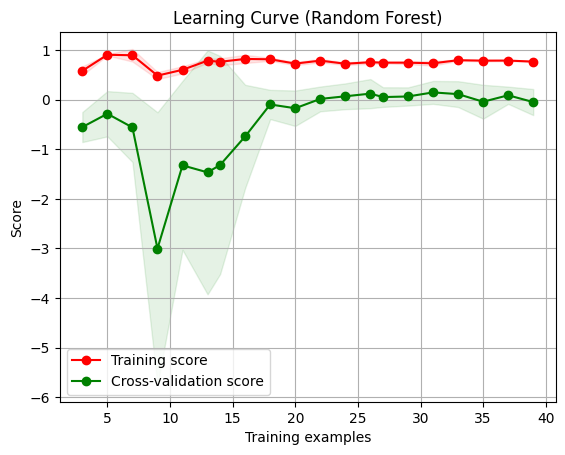

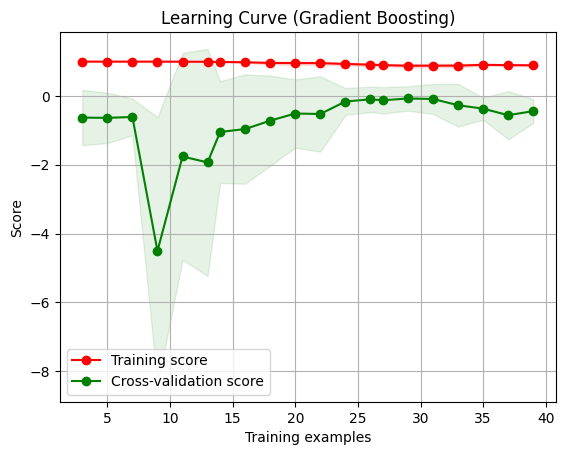

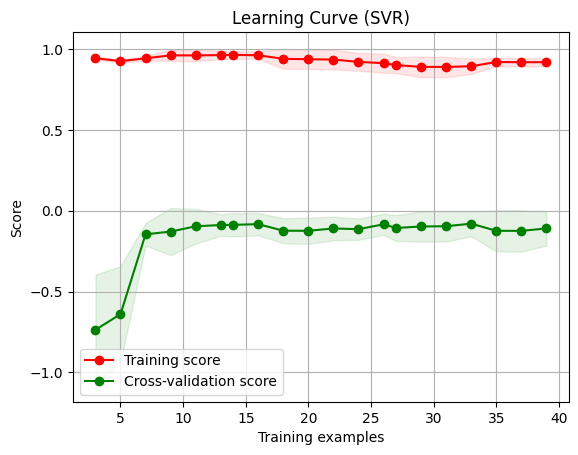

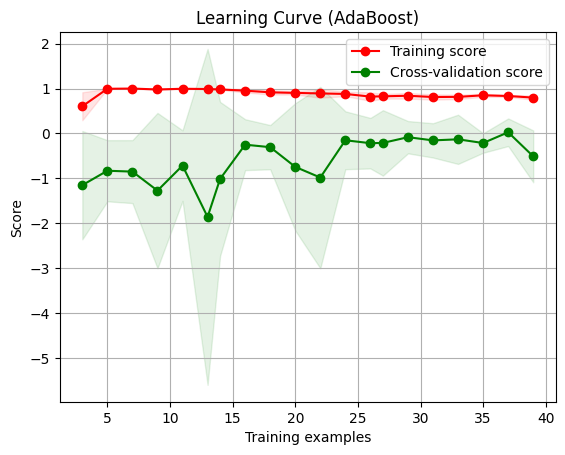

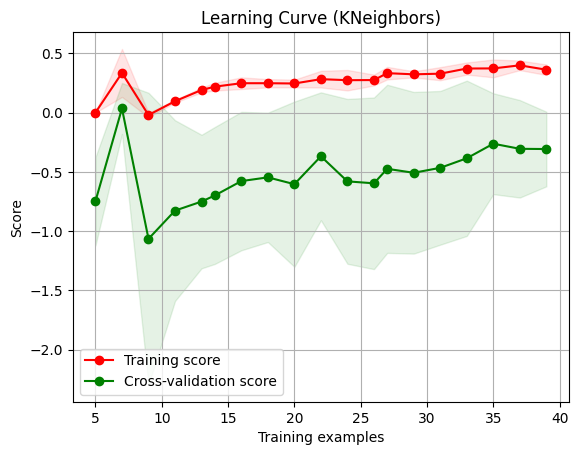

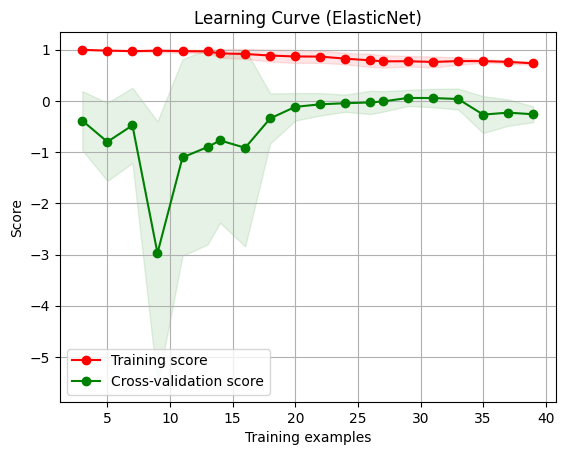

In [81]:
# Graficar la curva de aprendizaje para cada modelo
plot_learning_curve(rf_model, "Learning Curve (Random Forest)", X_train, Y_train, cv=5)
plt.show()

plot_learning_curve(gb_model, "Learning Curve (Gradient Boosting)", X_train, Y_train, cv=5)
plt.show()

plot_learning_curve(svr_model, "Learning Curve (SVR)", X_train, Y_train, cv=5)
plt.show()

plot_learning_curve(ada_model, "Learning Curve (AdaBoost)", X_train, Y_train, cv=5)
plt.show()

plot_learning_curve(knn_model, "Learning Curve (KNeighbors)", X_train, Y_train, cv=5)
plt.show()

plot_learning_curve(elastic_model, "Learning Curve (ElasticNet)", X_train, Y_train, cv=5)
plt.show()

### **Análisis del Modelo**

**Desempeño en el Conjunto de Entrenamiento**

En la gráfica del conjunto de entrenamiento (izquierda), observamos que las predicciones del modelo (Predicted pIC50) se alinean razonablemente bien con los valores experimentales (Experimental pIC50), aunque la relación lineal muestra cierta dispersión. Esto sugiere que el modelo ha capturado algunas de las tendencias en los datos de entrenamiento, pero no con una precisión perfecta.

**Desempeño en el Conjunto de Prueba**

En la gráfica del conjunto de prueba (derecha), las predicciones del modelo muestran una mayor dispersión y una alineación más débil con los valores experimentales. La relación lineal es menos pronunciada, lo que indica que el modelo tiene dificultades para generalizar a datos no vistos durante el entrenamiento.

**Evaluación del Modelo**

El desempeño del modelo en el conjunto de entrenamiento es mejor que en el conjunto de prueba, lo que sugiere que el modelo podría estar sobreentrenado. Sin embargo, la diferencia no es extremadamente marcada. La dispersión en ambas gráficas indica que el modelo no está capturando todas las variabilidades de los datos.

**Conclusión**

Basado en las gráficas obtenidas, el modelo muestra indicios de sobreentrenamiento. El modelo ha aprendido algunos patrones en los datos de entrenamiento, pero no puede generalizar bien a nuevos datos (conjunto de prueba). Este comportamiento puede atribuirse a la complejidad del modelo o a una posible necesidad de más datos de entrenamiento.

### Conclusiones de fase "Baseline"

**Justificación del Algoritmo Seleccionado**

Para abordar el problema de identificar compuestos químicos que inhiban la proteína VEGF165, se seleccionó el algoritmo de Random Forest. Esta elección es adecuada por varias razones:

1. **Datos Estructurados:** El problema maneja datos estructurados, específicamente descriptores químicos representados como fingerprints moleculares generados mediante PaDEL. Random Forest es muy eficaz para este tipo de datos debido a su capacidad para manejar una gran cantidad de características y detectar interacciones complejas entre ellas.

2. **Cantidad de Datos:** Aunque no se cuenta con una enorme cantidad de datos, Random Forest es robusto y puede trabajar eficientemente con conjuntos de datos de tamaño moderado. Además, al ser un ensemble de árboles, reduce el riesgo de sobreentrenamiento en comparación con un solo árbol de decisión.

3. **Relevancia de las Características:** Todos los descriptores están representados mediante fingerprints y, por lo tanto, no se considera que algunas características sean más importantes que otras a priori. La selección de características mediante VarianceThreshold se utiliza para eliminar aquellas con baja variabilidad, asegurando que sólo se incluyan características relevantes y con información.

4. **Interpretabilidad:** Aunque los modelos de Random Forest no son tan interpretables como los modelos lineales, su capacidad para manejar grandes conjuntos de datos y muchas características sin necesidad de una ingeniería de características exhaustiva hace que sea una herramienta poderosa para este tipo de problemas.

**Análisis de la Relevancia de las Características**

Se utilizó la técnica de selección de características **VarianceThreshold** para eliminar las características con baja variabilidad, lo que ayuda a reducir el ruido y mejorar la eficiencia del modelo.

**Comparación de Métricas de Evaluación**
Para evaluar el modelo, se utilizó el coeficiente de determinación
${R^2}$ debido a su relevancia en este contexto. ${R^2}$ mide la proporción de la variabilidad en la variable dependiente (pIC50) que es explicada por las características independientes del modelo. Es una métrica adecuada ya que:

1. **Contexto del Negocio:** Dado que el objetivo es identificar compuestos con el menor pIC50, un alto ${R^2}$ indicará que el modelo explica bien la variabilidad en pIC50, lo que es crucial para seleccionar los compuestos más prometedores.

2. **Interpretación:** ${R^2}$ proporciona una interpretación clara y directa sobre el desempeño del modelo en términos de explicación de la varianza, facilitando la toma de decisiones en el contexto de la investigación química.

**Desempeño Mínimo Esperado**

El objetivo es identificar al menos cinco compuestos con el menor pIC50. Históricamente, un modelo base podría ser una regresión lineal simple o un modelo de vecino más cercano (KNN). El modelo Random Forest debe superar este baseline, proporcionando un ${R^2}$ significativamente mayor.

En el análisis, se determinó que el modelo de Random Forest presenta un sobreentrenamiento, dado que el desempeño en el conjunto de entrenamiento es mejor que en el conjunto de prueba. Para mitigar este sobreentrenamiento, se pueden considerar técnicas adicionales como la validación cruzada más intensiva, el ajuste de hiperparámetros o la recopilación de más datos.

**Conclusión final**

El modelo Random Forest es apropiado para el problema de identificar compuestos químicos que inhiban la proteína VEGF165 debido a su capacidad para manejar datos estructurados con muchas características y proporcionar información sobre la importancia de las mismas. Aunque el modelo muestra signos de sobreentrenamiento, es posible mejorar su generalización con técnicas adicionales. El coeficiente de determinación ${R^2}$ es la métrica más adecuada para evaluar este modelo, dado su alineamiento con los objetivos del problema y su capacidad para proporcionar una interpretación clara de la variabilidad explicada en pIC50. Con estos ajustes y consideraciones, el modelo puede ser una herramienta valiosa para seleccionar los compuestos más prometedores.

## Referencias bibliográficas
Yap, C. W. (2011). PaDEL‐descriptor: An open source software to calculate molecular descriptors and fingerprints. Journal of computational chemistry, 32(7), 1466-1474.
Segal, M. R. (2004). Machine learning benchmarks and random forest regression.